In [1]:
import os
import pandas as pd
import numpy as np
import plotnine as p9

In [2]:
# list output files
file_paths = os.listdir(os.path.join('data', 'results'))
# keep only .csv files
results = [pd.read_csv(os.path.join('data', 'results', p)) for p in file_paths if p.endswith('.csv')]

In [3]:
results = pd.concat(results)

In [4]:
results['mean_auc'] = results.groupby(['reduction_name', 'dataset', 'score_key'])['auroc'].transform('mean')
results['mean_f1'] = results.groupby(['reduction_name', 'dataset', 'score_key'])['f1_score'].transform('mean')

In [5]:
results

,reduction_name,score_key,state,fold,auroc,tpr,fpr,f1_score,oob_score,train_split,test_split,test_classes,dataset,mean_auc,mean_f1
0,mofa,expr_prod,0,0,0.666667,[0. 0. 1. 1.],[0. 0.33333333 0.33333333 1. ],0.708333,0.571429,[ 0 1 2 3 5 6 7 8 10 14 15 17 20 21],[ 4 9 11 12 13 16 18 19],[1 0 0 1 1 0 1 1],carraro,0.588605,0.548167
1,tensor,expr_prod,0,0,0.666667,[0. 0.16666667 0.33333333 0.33333333 1...,[0. 0. 0. 0.5 0.5 1. ],0.642857,0.357143,[ 0 1 2 3 5 6 7 8 10 14 15 17 20 21],[ 4 9 11 12 13 16 18 19],[1 0 0 1 1 0 1 1],carraro,0.518333,0.517662
2,mofa,lr_logfc,0,0,0.600000,[0. 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1. ],[0. 0. 0. 0.33333333 0...,0.480769,0.357143,[ 0 1 2 3 5 6 7 8 10 14 15 17 20 21],[ 4 9 11 12 13 16 18 19],[1 0 0 1 1 0 1 1],carraro,0.529911,0.488054
3,tensor,lr_logfc,0,0,0.916667,[0. 0.16666667 0.83333333 0.83333333 1...,[0. 0. 0. 0.5 0.5 1. ],0.642857,0.642857,[ 0 1 2 3 5 6 7 8 10 14 15 17 20 21],[ 4 9 11 12 13 16 18 19],[1 0 0 1 1 0 1 1],carraro,0.675278,0.602626
4,mofa,lr_means,0,0,0.466667,[0. 0. 0.6 0.6 0.8 0.8 1. ],[0. 0.33333333 0.33333333 0.66666667 0...,0.416667,0.714286,[ 0 1 2 3 5 6 7 8 10 14 15 17 20 21],[ 4 9 11 12 13 16 18 19],[1 0 0 1 1 0 1 1],carraro,0.633631,0.528514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,tensor,lr_probs,4,2,0.833333,[0. 0.25 0.75 0.75 1. 1. ],[0. 0. 0. 0.66666667 0...,0.714286,0.625000,[ 2 3 4 5 6 7 8 9 12 15 16 17 19 20 21 22],[ 0 1 10 11 13 14 18],[1 1 1 0 0 1 0],kuppe,0.832917,0.762080
176,mofa,lrscore,4,2,0.916667,[0. 0.5 0.75 0.75 1. 1. ],[0. 0. 0. 0.33333333 0...,0.714286,1.000000,[ 2 3 4 5 6 7 8 9 12 15 16 17 19 20 21 22],[ 0 1 10 11 13 14 18],[1 1 1 0 0 1 0],kuppe,0.952222,0.828259
177,tensor,lrscore,4,2,0.375000,[0. 0.25 0.25 0.5 0.75 1. ],[0. 0. 0.66666667 0.66666667 1...,0.404762,0.500000,[ 2 3 4 5 6 7 8 9 12 15 16 17 19 20 21 22],[ 0 1 10 11 13 14 18],[1 1 1 0 0 1 0],kuppe,0.665139,0.620772
178,mofa,magnitude_rank,4,2,1.000000,[0. 0.25 1. 1. ],[0. 0. 0. 1.],0.857143,1.000000,[ 2 3 4 5 6 7 8 9 12 15 16 17 19 20 21 22],[ 0 1 10 11 13 14 18],[1 1 1 0 0 1 0],kuppe,0.991111,0.873025


In [6]:
results['score_key'].unique()

remap_dict = {'lr_means':'CellPhoneDB',
              'expr_prod':'Product',
              'lr_logfc': 'logFC',
              'lrscore': 'SingleCellSignalR',
              'lr_probs': 'CellChat',
              'magnitude_rank':'Consensus'}
results['score_key'] = results['score_key'].map(remap_dict)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 6 rows containing non-finite values.


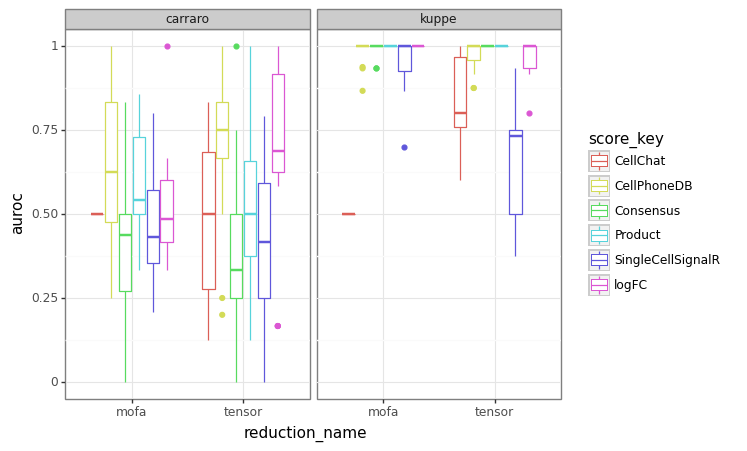

<ggplot: (8748190921713)>

In [8]:
## plot results as boxplots by reduction_name & score_key
p9.ggplot(results, p9.aes(x='reduction_name', y='auroc', color='score_key')) + \
    p9.geom_boxplot() + \
    p9.theme_bw() + p9.facet_grid(' ~ dataset')

In [9]:
metric = 'mean_auc'

In [10]:
results = results[['reduction_name', 'score_key', 'mean_auc', 'mean_f1', 'dataset']].drop_duplicates()

In [11]:
results['rank'] = results.groupby(['dataset', 'reduction_name'])[metric].rank(ascending=False, method='average').astype('int')

In [12]:
results.head()

,reduction_name,score_key,mean_auc,mean_f1,dataset,rank
0,mofa,Product,0.588605,0.548167,carraro,2
1,tensor,Product,0.518333,0.517662,carraro,3
2,mofa,logFC,0.529911,0.488054,carraro,3
3,tensor,logFC,0.675278,0.602626,carraro,2
4,mofa,CellPhoneDB,0.633631,0.528514,carraro,1


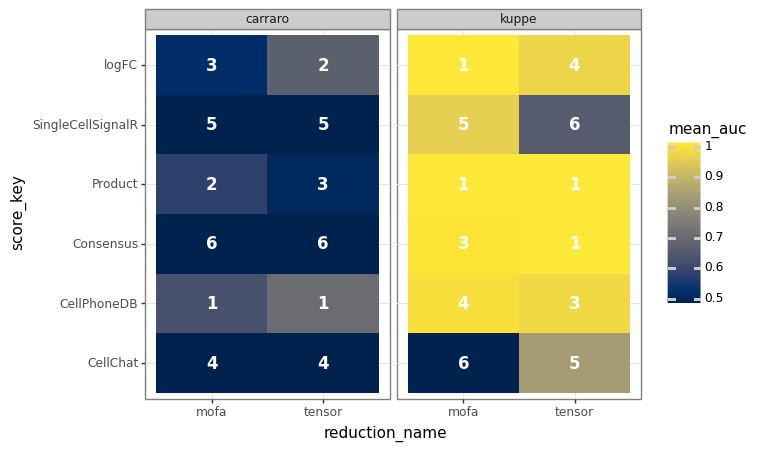

<ggplot: (8748303510393)>

In [13]:
## mosaic plot
p9.ggplot(results, p9.aes(x='reduction_name', y='score_key', fill='mean_auc')) + \
    p9.geom_tile() + \
        p9.theme_bw() + p9.facet_grid(' ~ dataset') + \
            p9.scale_fill_cmap(limits=(0.5, 1), cmap_name='cividis') + \
            p9.geom_text(p9.aes(label='rank'), size=12, color='white', fontweight='bold')

In [69]:
dimred_results = results.groupby(['reduction_name', 'score_key']).mean().reset_index()

/tmp/ipykernel_513474/2054308315.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


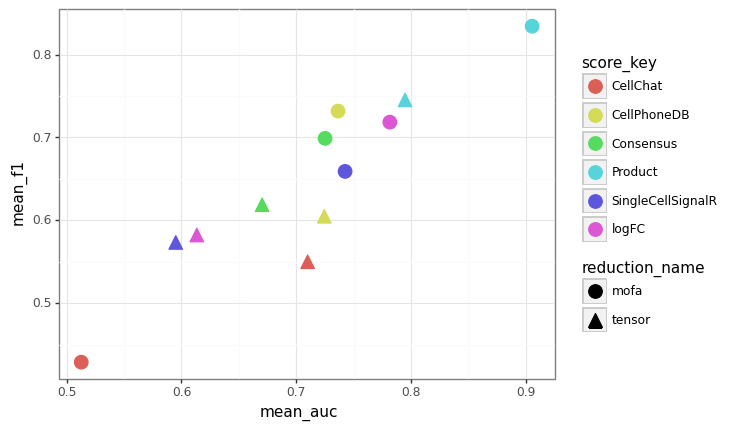

<ggplot: (8729558713591)>

In [71]:
## scatter plot by reduction_name
p9.ggplot(dimred_results, p9.aes(x='mean_auc', y='mean_f1', color='score_key', shape='reduction_name')) + \
    p9.geom_point(size=5) + \
        p9.theme_bw()